In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [33]:

Image_Size = 256
Batch_Size = 32
channels = 3
Epochs = 25
input_shape = (Batch_Size,Image_Size,Image_Size,channels)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Others",
    shuffle = True,
    image_size = (Image_Size,Image_Size),
    batch_size = Batch_Size
)

Found 9359 files belonging to 7 classes.


In [5]:
df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = df.class_names
class_names = [class_name for class_name in class_names if class_name != '.ipynb_checkpoints']

class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

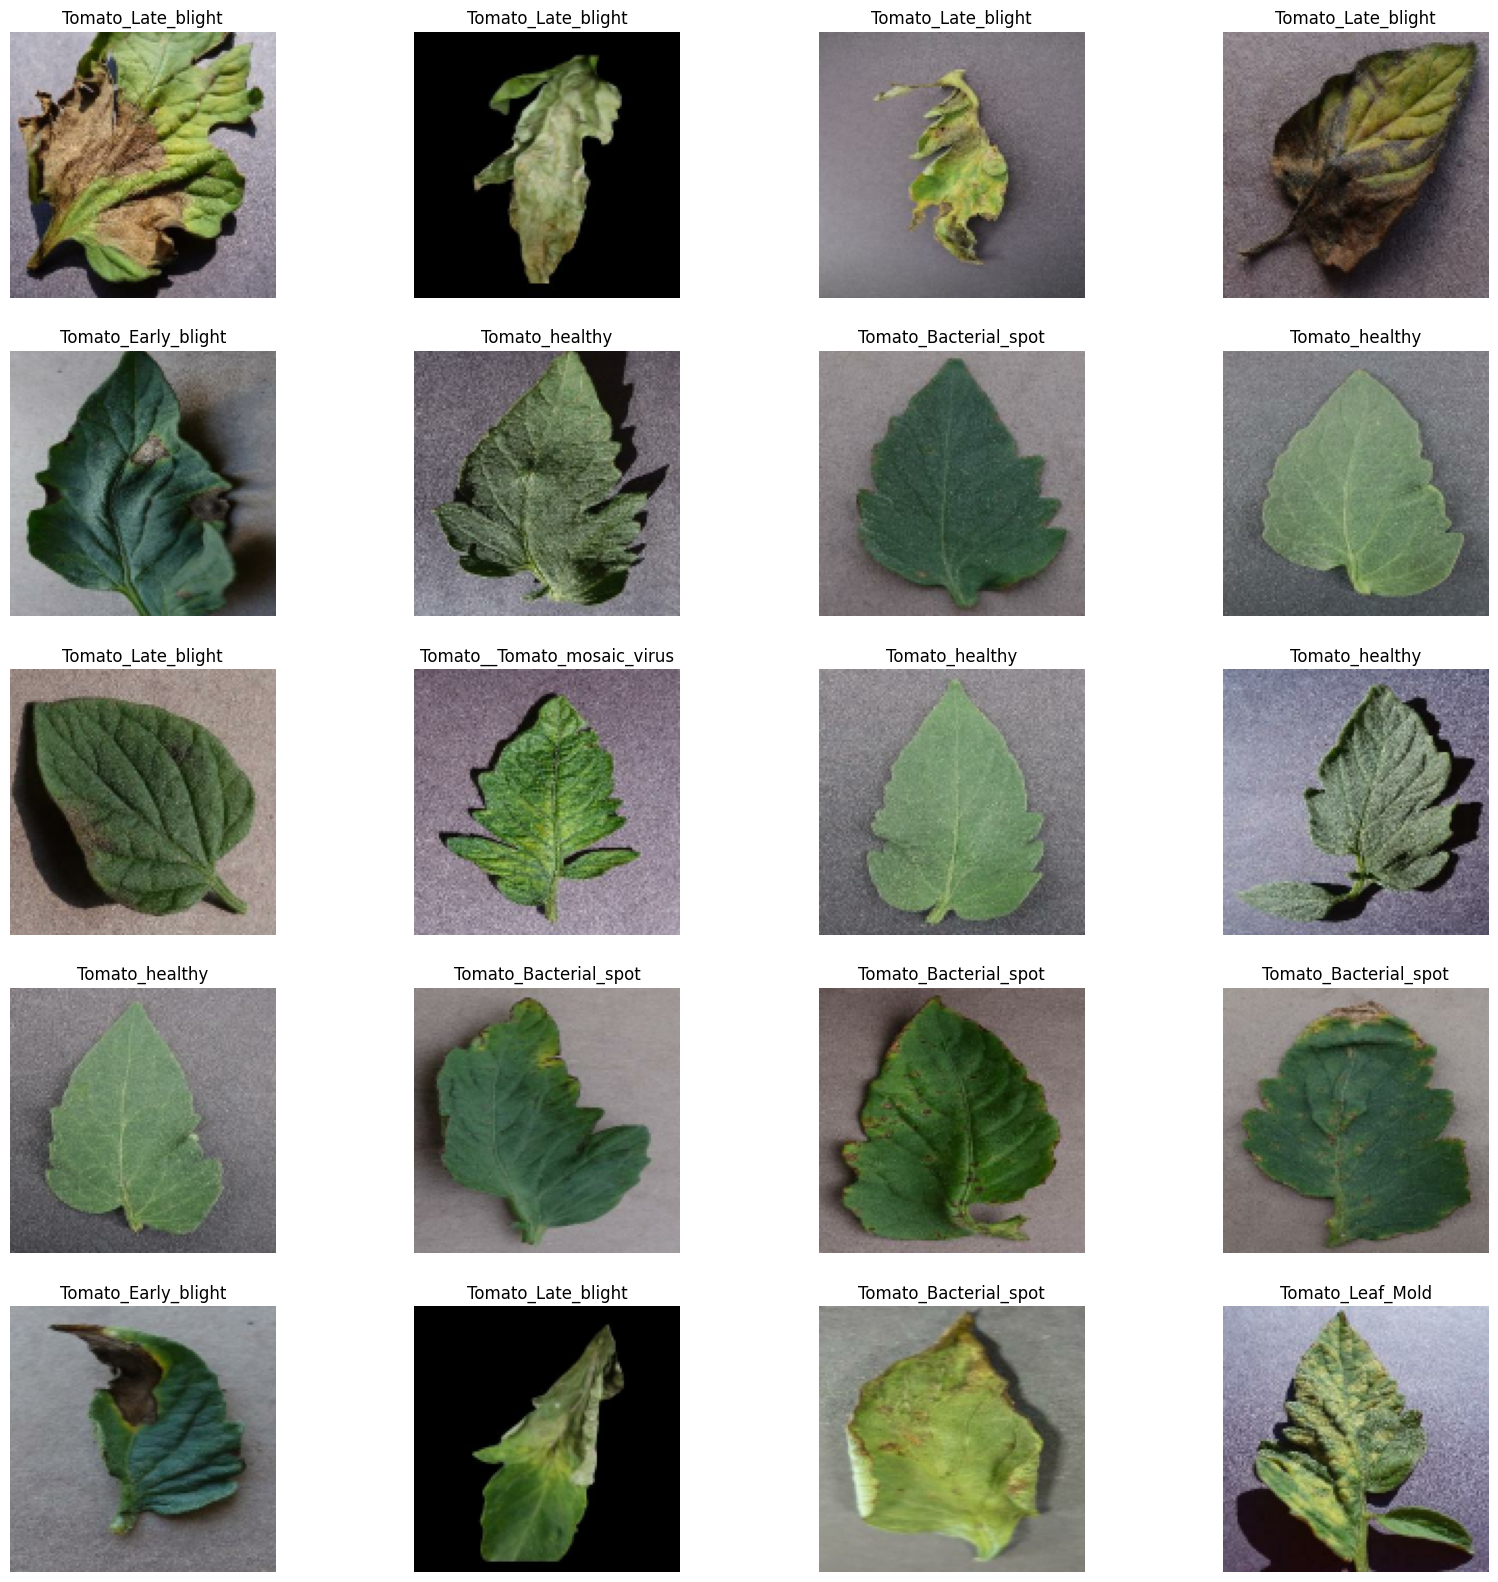

In [7]:
plt.figure(figsize=(20,20))
for image, label in df.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
#     print(image.shape)
#     print(label.numpy())

In [34]:
def get_part(df, tr_s = 0.8, te_s = 0.1, v_s = 0.1, shuffle = True, s_size = 1000):
    df_size = len(df)

    if shuffle:
        df = df.shuffle(s_size, seed = 12)

    train_size = int(tr_s * df_size)
    val_size = int(v_s * df_size)

    train_ds = df.take(train_size)

    val_ds = df.skip(train_size).take(val_size)
    test_ds = df.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [35]:
train_ds, val_ds, test_ds = get_part(df)

In [36]:
len(train_ds)

234

In [37]:
len(test_ds)

30

In [38]:
len(val_ds)

29

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [40]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])



In [41]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(.2)
])

In [44]:
model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation = 'softmax')
])

model.build(input_shape= input_shape)

In [45]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [46]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = 'accuracy')

In [47]:
history = model.fit(train_ds,
                   epochs=Epochs,
                   batch_size=Batch_Size,
                   verbose=1,
                   validation_data=val_ds)

Epoch 1/25
234/234 [==============================] - 44s 115ms/step - loss: 1.5636 - accuracy: 0.4032 - val_loss: 1.1109 - val_accuracy: 0.6175
Epoch 2/25
234/234 [==============================] - 13s 55ms/step - loss: 0.9780 - accuracy: 0.6501 - val_loss: 0.7359 - val_accuracy: 0.7252
Epoch 3/25
234/234 [==============================] - 13s 56ms/step - loss: 0.7240 - accuracy: 0.7432 - val_loss: 0.7937 - val_accuracy: 0.7295
Epoch 4/25
234/234 [==============================] - 13s 56ms/step - loss: 0.5475 - accuracy: 0.8086 - val_loss: 0.5454 - val_accuracy: 0.8254
Epoch 5/25
234/234 [==============================] - 13s 56ms/step - loss: 0.4498 - accuracy: 0.8424 - val_loss: 0.3691 - val_accuracy: 0.8631
Epoch 6/25
234/234 [==============================] - 13s 55ms/step - loss: 0.4163 - accuracy: 0.8532 - val_loss: 0.2890 - val_accuracy: 0.8933
Epoch 7/25
234/234 [==============================] - 13s 56ms/step - loss: 0.3537 - accuracy: 0.8747 - val_loss: 0.3512 - val_accuracy

In [48]:
scores = model.evaluate(test_ds)

30/30 [==============================] - 13s 17ms/step - loss: 0.1020 - accuracy: 0.9635


In [49]:
scores

[0.10203874111175537, 0.9635416865348816]

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

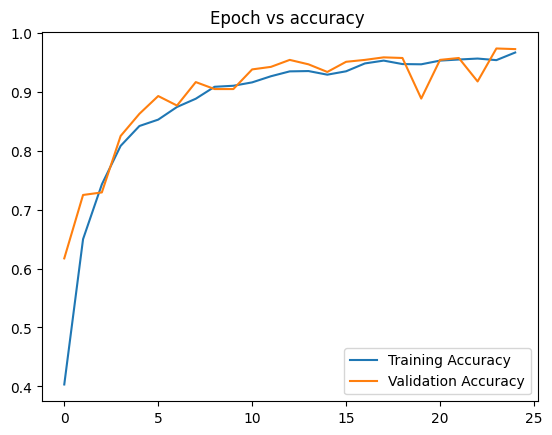

In [51]:
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.title("Epoch vs accuracy ")
plt.legend()

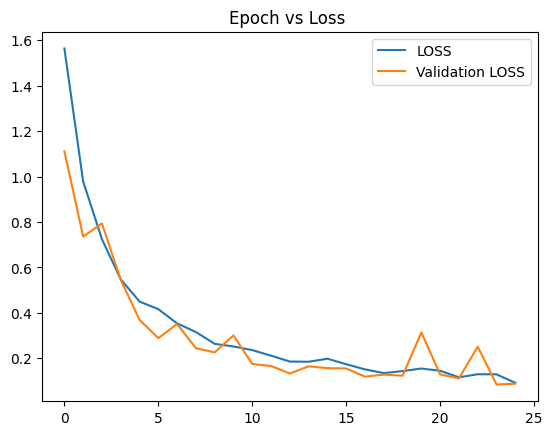

In [52]:
plt.plot(range(Epochs), loss, label = "LOSS")
plt.plot(range(Epochs), val_loss, label = "Validation LOSS")
plt.title("Epoch vs Loss ")
plt.legend()

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


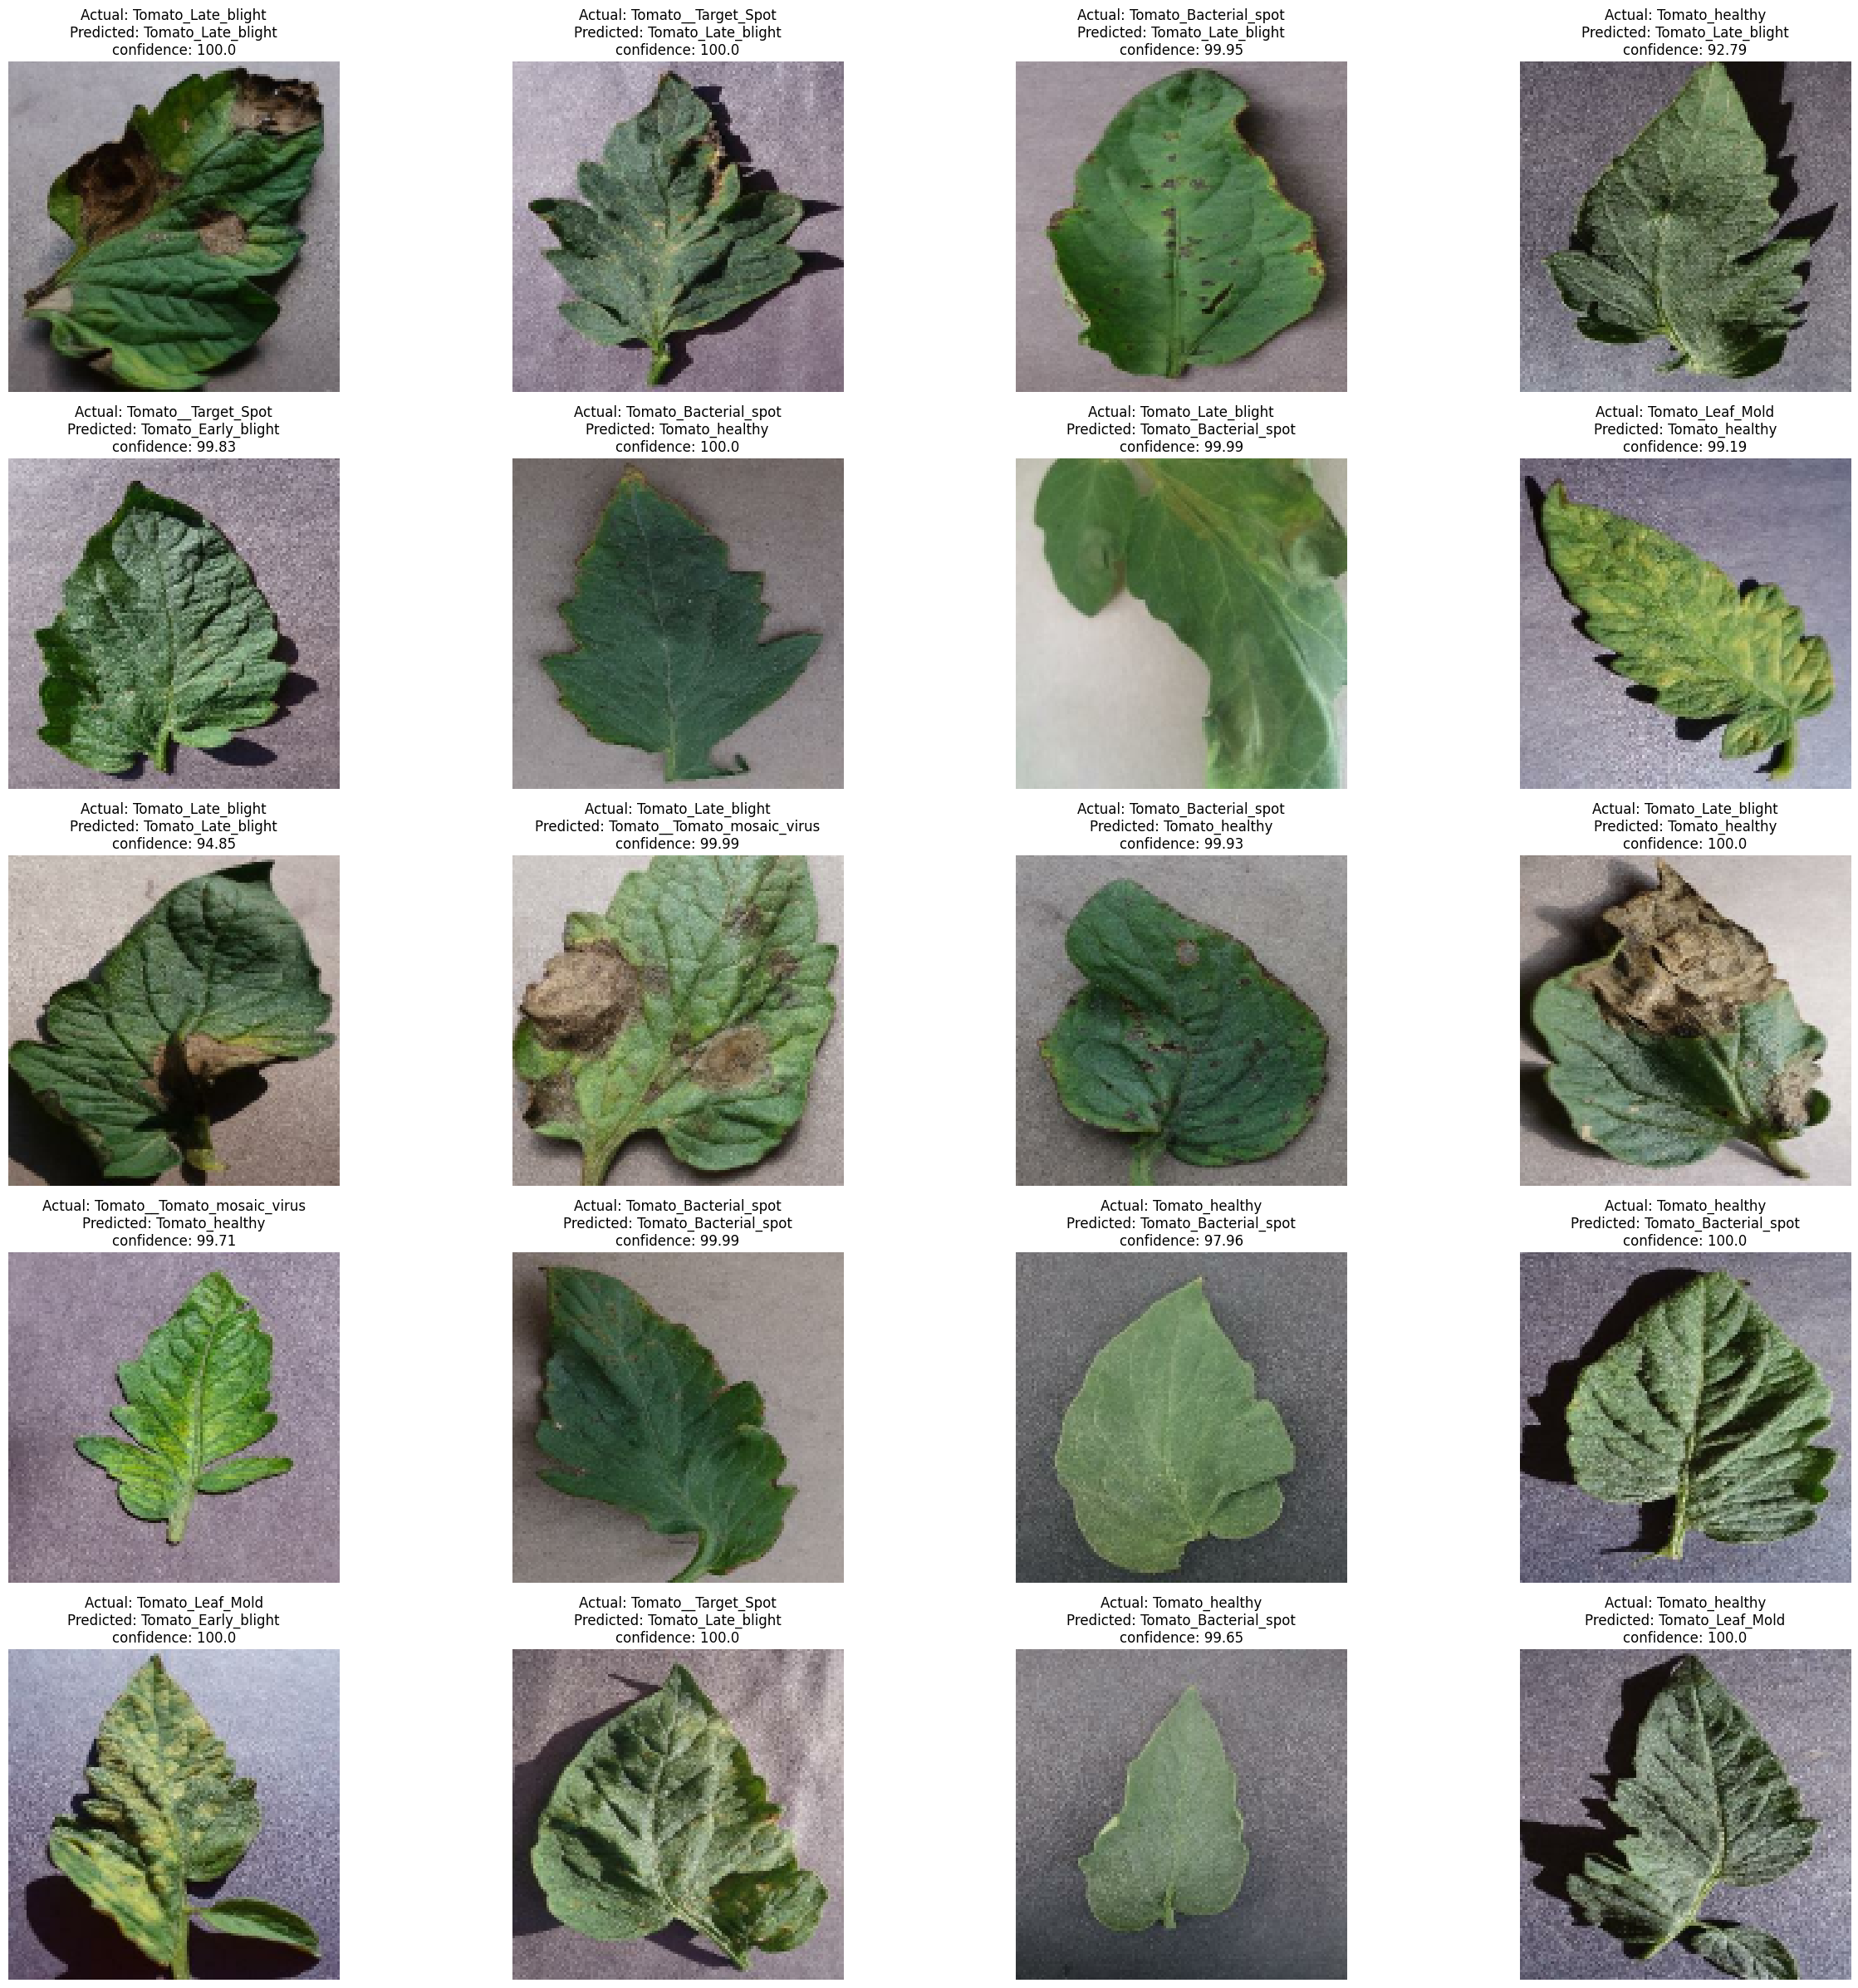

In [55]:
plt.figure(figsize=(30,30))

for images, label in test_ds.take(1):
    for i in range (20):

        ax = plt.subplot(5,4, i+1)

        plt.imshow(images[i].numpy().astype('uint8'))

        pred, con = predict(model, images[i].numpy())
        actual_class = class_names[label[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {pred}\nconfidence: {con}")

        plt.axis('off')